In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

import arviz as az

In [2]:
az.style.use('arviz-white')

# Step-by-step illustration of Metropolis sampling for a 1D posterior

In [3]:
def post(theta, Y, pri_mn=0, pri_sd=1):
    """
    Function to compute the posterior distribution:

    Likelihood: Y[i] ~ Bern(expit(theta))
    Prior:      theta ~ Normal(pri_mn, pri_sd)
    """
    prob  = np.exp(theta) / (1 + np.exp(theta))
    prior = stats.norm(pri_mn, pri_sd).pdf(theta)
    like  = stats.bernoulli(prob).pmf(Y).prod()
    return like * prior

## Generate fake data

In [4]:
np.random.seed(820)
Y = stats.bernoulli(0.7).rvs(20)

## Compute the posterior on a grid for reference

In [5]:
theta_grid = np.linspace(-3, 3, 100)
dense = np.zeros(100)
for i in range(100):
    dense[i] = post(theta_grid[i], Y)

##  MCMC set-up

In [6]:
n_iters = 1000
can_sd = 0.5  # Try different values of can_sd to see the effect on the acceptance rate

# initial value

theta = 0
keep_theta = np.zeros(n_iters)
keep_can = np.zeros(n_iters)

# Go!
for iter in range(n_iters):
    # Draw a candidate and compute acceptance ratio:
    can = stats.norm(theta, can_sd).rvs(1)
    p1 = post(can, Y)
    p2 = post(theta, Y)
    R = p1/p2
    R = 1 if R > 1 else R
    
    
    
    # Make a decision: 
    keep = stats.bernoulli(R).rvs(1) == 1
    if keep:
        theta = can

    keep_theta[iter] = theta
    keep_can[iter] = can

## Plot the results

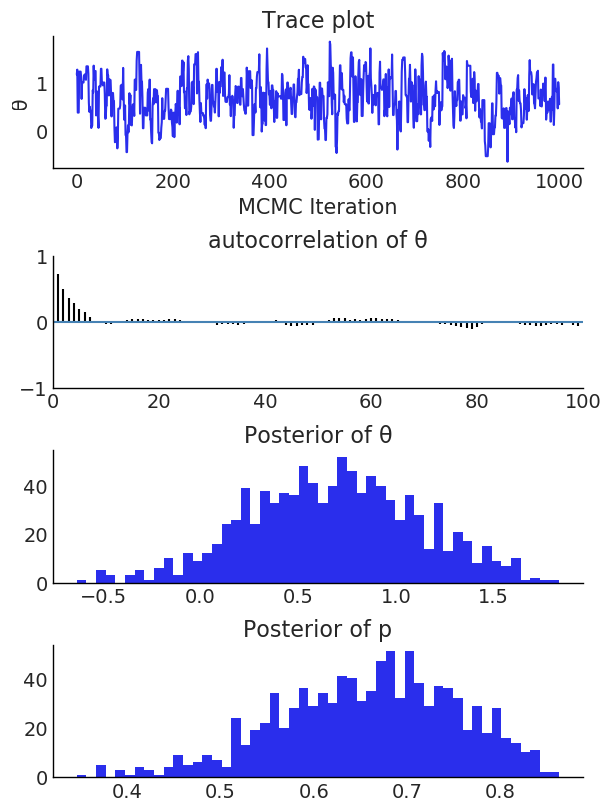

In [7]:
_, ax = plt.subplots(4, 1, figsize=(6, 8), constrained_layout=True)

ax[0].plot(keep_theta)
ax[0].set_xlabel("MCMC Iteration")
ax[0].set_ylabel("θ")
ax[0].set_title("Trace plot")
axes = az.plot_autocorr(keep_theta, ax=ax[1])
axes[0, 0].set_title('autocorrelation of θ')
ax[2].hist(keep_theta, bins=50)
ax[2].set_title("Posterior of θ")
keep_p = np.exp(keep_theta) / (1 + np.exp(keep_theta))
ax[3].hist(keep_p, bins=50)
ax[3].set_title("Posterior of p");